#### ।।ॐ श्री गणेशाय नमः।।

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import glob
import os
import pandas as pd
from torchvision.io import read_image
import cv2
import json
from PIL import Image
import torch, torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import pdb
import tensorflow_hub as hub

## Stage 1: Data Loader

In [2]:
traindir = [r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\train\rupee_1\*.*", r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\train\rupee_2\*.*", r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\train\rupee_5\*.*", r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\train\rupee_10\*.*"]
testdir = [r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\test\rupee_1\*.*", r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\test\rupee_2\*.*", r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\test\rupee_5\*.*", r"C:\Users\Mangalam\Downloads\1. Research\Currency Detection\naveen_dataset\test\rupee_10\*.*"]
img_paths = []
labels = []

In [3]:
class CustomImageTrainDataset():
    def __init__(self):
        # search all files inside a specific folder
        # *.* means file name with any extension

        for i, dir in enumerate(traindir):
            paths = glob.glob(dir)
            for path in paths:
                img_paths.append(path)
                labels.append(i)
        
        self.img_labels = labels
        self.img_dir = img_paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # print(idx)
        img_path = os.path.join(self.img_dir[idx])
        # print(img_path)
                
        image = Image.open(img_path)
        transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.RandomResizedCrop((200,200)),
            # transforms.RandomRotation(degrees=30),
            #transforms.ColorJitter(),
            transforms.Resize((64,64))])
        img_tensor = transform(image)
        
        label = self.img_labels[idx]
        # npimg = np.array(image)
        return img_tensor, label

class CustomImageTestDataset():
    def __init__(self):
        # search all files inside a specific folder
        # *.* means file name with any extension
        
        for i, dir in enumerate(testdir):
            paths = glob.glob(dir)
            for path in paths:
                img_paths.append(path)
                labels.append(i)
        
        self.img_labels = labels
        self.img_dir = img_paths
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir[idx])
        # image = read_image(img_path)
        label = self.img_labels[idx]

        image = Image.open(img_path)
        transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.RandomResizedCrop((200,200)),
            transforms.RandomRotation(degrees=30),
            #transforms.ColorJitter(),
            transforms.Resize((64,64))])
        img_tensor = transform(image)

        
        return img_tensor, label

In [4]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = CustomImageTrainDataset()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CustomImageTestDataset()

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('1 Rupee Coin', '2 Rupee Coin', '5 Rupee Coin', '10 Rupee Coin', )

1983
torch.Size([3, 530, 530])
torch.Size([530, 530])


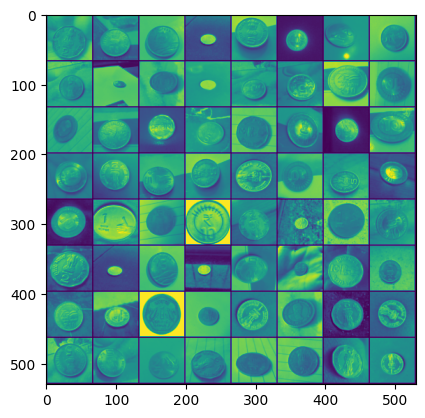

In [5]:
#Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    print(img.shape)
    result = img[0, :, :]
    print(result.shape)
    plt.imshow(result)
    plt.show()


# get some random training images
# print(len(testset))
print(testset.__len__())
# trainset.__getitem__(7)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join(f'{label[labels[j]]:5s}' for j in range(batch_size)))

## Stage 2: CNN Backbone

In [6]:
# CUSTOM NET

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        pdb.set_trace()
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
# Custom Net New

class CustomSpatialAttention(nn.Module):
  """
  Custom spatial attention layer to focus on important regions.
  """
  def __init__(self, channels):
    super(CustomSpatialAttention, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(channels, 1, kernel_size=1)  # Output channel = 1 for attention weights

  def forward(self, x):
    # Apply convolution to capture spatial information
    attention = self.conv1(x)
    attention = F.relu(attention)  # Activation
    attention = self.conv2(attention)  # Reduce to 1 channel for weights
    attention = F.sigmoid(attention)  # Normalize attention weights (0-1)
    return x * attention  # Apply attention weights element-wise

class ImageClassifier(nn.Module):
  """
  Classifier with custom attention layer and standard components.
  """
  def __init__(self):
    super(ImageClassifier, self).__init__()
    self.custom_attention = CustomSpatialAttention(3)  # Input channels = 3 (assuming RGB)
    # Standard convolutional layers (you can adjust the architecture as needed)
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(32 * 16 * 16, 64)  # Assuming output of conv2 is 32 channels, 16x16 spatial dimensions
    self.fc2 = nn.Linear(64, 4)  # 4 output classes

  def forward(self, x):
    x = self.custom_attention(x)
    x = self.conv1(x)
    x = self.pool(F.relu(x))
    x = self.conv2(x)
    x = self.pool(F.relu(x))
    x = torch.flatten(x, 1)  # Flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Example usage (assuming you have your data loaders)
custom_clf = ImageClassifier()

In [11]:
# ResNet New

class CustomSpatialAttention(nn.Module):
  """
  Custom spatial attention layer to focus on important regions.
  """
  def __init__(self, channels):
    super(CustomSpatialAttention, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(channels, 1, kernel_size=1)  # Output channel = 1 for attention weights

  def forward(self, x):
    # Apply convolution to capture spatial information
    print(x.shape)
    attention = self.conv1(x)
    attention = F.relu(attention)  # Activation
    attention = self.conv2(attention)  # Reduce to 1 channel for weights
    attention = F.sigmoid(attention)  # Normalize attention weights (0-1)
    return x * attention  # Apply attention weights element-wise

class ResNet50Classifier(nn.Module):
  """
  Classifier with custom attention layer on top of pre-trained ResNet-50.
  """
  def __init__(self, num_classes):
    super(ResNet50Classifier, self).__init__()
    self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    # Freeze the pre-trained layers (optional)
    for param in self.resnet.parameters():
      param.requires_grad = False
        
    # Replace the final fc layer with our custom layers
    self.reduce_channels = nn.Conv2d(2048, 64, kernel_size=1)  # Adjust output channels as needed
    self.custom_attention = CustomSpatialAttention(64)  # Input channels adjusted
    self.fc1 = nn.Linear(64, 512)  # Adjust hidden layer size as needed
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    # Pass through pre-trained ResNet-50 (excluding the final fc layer)
    x = self.resnet(x)
    print(x.shape)
    x = self.custom_attention(x)
    x = torch.flatten(x, 1)  # Flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Example usage (assuming you have your data loaders)
resnet_clf = ResNet50Classifier(4)

In [8]:
#ALEXNET

class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        alexnet = models.alexnet(weights=True)
        self.backbone = torch.nn.Sequential(*(list(alexnet.children())[:-1]))
        
        self.Linear = nn.Linear(256, 128)
        self.Linear2 = nn.Linear(128, 128)
        self.Linear3 = nn.Linear(128, 128)
        self.Linear4 = nn.Linear(128, 4)
        
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
    

    def forward(self, x):
        x = self.backbone(x)
        # print(x.shape) 
        x = torch.mean(torch.mean(x, 2), 2)
        x = F.relu(self.Linear(x))
        x = F.relu(self.Linear2(x))
        x = F.relu(self.Linear3(x))
        x = self.Linear4(x)
        
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        
        return x


alexnet = AlexNet()

C:\Users\Mangalam\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# YOLOnet

class YOLONet(nn.Module):
    def __init__(self):
        super().__init__()

        #juicy part
        yolomodel = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        self.backbone = torch.nn.Sequential(*list(yolomodel.modules())[:-2])
        
        # yolomodel = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        # self.backbone = torch.nn.Sequential(*(list(list((list(list(yolomodel.children())[0].children())[0]).children())[0])[:-1]))
        
        self.Linear = nn.Linear(256, 128)
        self.Linear2 = nn.Linear(128, 128)
        self.Linear3 = nn.Linear(128, 128)
        self.Linear4 = nn.Linear(128, 4)
        
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
    

    def forward(self, x):
        x = self.backbone(x)
        # print(x.shape) 
        x = torch.mean(torch.mean(x, 2), 2)
        x = F.relu(self.Linear(x))
        x = F.relu(self.Linear2(x))
        x = F.relu(self.Linear3(x))
        x = self.Linear4(x)
        
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        
        return x


yolonet = YOLONet()

Using cache found in C:\Users\Mangalam/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-4-2 Python-3.9.13 torch-2.2.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Stage 3: Varying of Parameters
##### 1. Batch Size
##### 2. Optimizer
##### 3. Learning Rate
##### 4. Epochs
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [10]:
# ResNet

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = torch.nn.Sequential(*(list(resnet.children())[:-1]))
        
        self.Linear = nn.Linear(2048, 128)
        self.Linear2 = nn.Linear(128, 128)
        self.Linear3 = nn.Linear(128, 128)
        self.Linear4 = nn.Linear(128, 4)
        
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
    

    def forward(self, x):
        x = self.backbone(x)
        # print(x.shape) 
        x = torch.mean(torch.mean(x, 2), 2)
        # print(x.shape) 

        x = F.relu(self.Linear(x))
        x = F.relu(self.Linear2(x))
        x = F.relu(self.Linear3(x))
        x = self.Linear4(x)
        
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        
        return x


resnet = ResNet()

## Stage 4: Training the Models

In [12]:
model = resnet

In [13]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.00, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
def acc_check():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # print (labels)
            # calculate outputs by running images through the network
            outputs = model(images)
            # print(outputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct // total
    return acc     

# print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [15]:
bestacc = 0
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(images.shape)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i:   ####*
            acc = acc_check()
            print(epoch, ': ', running_loss,', accuracy: ', acc)
            running_loss = 0.0
            if acc>bestacc:
                bestacc = acc
            

print('Finished Training\n', bestacc) 

0 :  2.767964005470276 , accuracy:  27


KeyboardInterrupt: 

## Stage 5: Testing Performance

In [ ]:
# dataiter = iter(testloader)
# images, labels = next(dataiter)

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# #obtaining predictions

# outputs = net(images)

In [ ]:
# #The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. 
# #So, let’s get the index of the highest energy:

# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
#                               for j in range(4)))

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')